In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
#import geoplot as gplt
import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

# 25_2, 25_4, 25_8, 50_1, 50_2, 50_4, 75_1, 75_3, 75_6
dataset = "UK25_2"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}


evaluation_amount = {"UK25":3000,"UK50":5000,"UK75":10000}

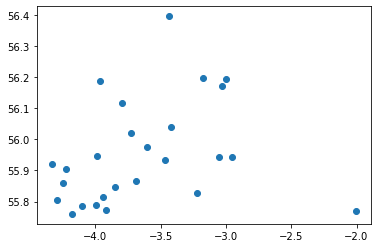

In [3]:
plt.scatter(x = points_coordinate[:,1],y=points_coordinate[:,0])
plt.show()

In [4]:
print(points_coordinate.max(axis=0))
print(points_coordinate.min(axis=0))

[56.3957679 -2.0026472]
[55.760176  -4.3332046]


In [5]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 30
amount_of_evaluations = evaluation_amount[dataset[:-2]]
observer_update_interval = 60
logpath = "parameter_data/reruns_L1/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error) 
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
            


[Errno 17] File exists: 'parameter_data/reruns_L1/UK25_2'


In [6]:
from datetime import timedelta
def time_string_to_minutes(time_string):
    """
    https://stackoverflow.com/a/60638687/12463908
    """
    
    h =time_string
    try:
        delta = timedelta(hours=int(h.split(':')[0]), minutes=int(h.split(':')[1]), seconds=int(h.split(':')[2]))
    except:
        if h != "00.00s":
            
            delta = timedelta(hours=0, minutes=int(h.split(':')[0]), seconds=int(h.split(':')[1]))
        else:
            delta = timedelta(hours=0, minutes=0, seconds=0)
    minutes = delta.total_seconds()/60
    return minutes

In [7]:
dataset_names = ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1", "UK75_3", "UK75_6"]
result_df = pd.DataFrame()
def gini_coefficient(x):
    """Compute Gini coefficient of array of values
    https://stackoverflow.com/a/61154922/12463908"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))
for dataset in dataset_names:

    api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

    # 25_2, 25_4, 25_8, 50_1, 50_2, 50_4, 75_1, 75_3, 75_6
    #dataset = "UK25_2"
    meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

    station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
    points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
    #dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
    #dbf = dbf.to_crs("EPSG:4326")
    meta_data["F-C Empty (l/100km)"] = 12.5
    meta_data["F-C Full (l/100km)"] = 15
    meta_data["Vehicle Weight"] = 3000

    distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

    distance_matrix_here = distance_matrix_here.to_numpy()
    time_matrix_here = time_matrix_here.to_numpy()

    routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
    startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
    endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

    startNodeIndeces = startNodes[dataset[:-2]]
    endNodeIndeces = endNodes[dataset[:-2]]
    locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

    vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


    vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)

    customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
    customer_demands[startNodeIndeces+endNodeIndeces] = 0
    station_data["Demand(kg)"] = customer_demands

    translate_dict = {}
    for i,x in enumerate(endNodeIndeces):
        translate_dict[x] = 100+i
    initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)






    







    
    init_sol_results = get_solution_results(solutions_SA,routingContext,vehicles,paths_to_use=initial_solution["paths"])
    init_sol_results_save = pd.DataFrame(init_sol_results[["Total distance (km)","Fuel Consumption (L)"]].sum()).T
    
    travel_times = [time_string_to_minutes(x) for x in init_sol_results["Total Travel Time (h)"]]
    init_sol_results_save["Total Travel Time (min)"] = sum(travel_times)
    init_sol_results_save["Max Travel Time (min)"] = max(travel_times)
    init_sol_results_save["Gini Index"] = gini_coefficient(np.array([time_string_to_minutes(x) for x in  init_sol_results["Total Travel Time (h)"]]))
    
    
    result_df = pd.concat([result_df,init_sol_results_save])
result_df.index = dataset_names
result_df = result_df.round(2)
print(result_df.to_latex())

NameError: name 'solutions_SA' is not defined

In [8]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# Simulated Annealing

In [10]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
from Problem.VRPGini import *

parameters_SA = optimal_parameters["SA"]

plot_data_SA = deepcopy(plot_data_storage_base)
for x in range(10):
    problem_SA = VRPGini(data_model_input_single_objective)
    problem_SA.name = "SA"
    problem_SA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(parameters_SA["mutation"]),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_SA])
    performance_observer_SA.maxEpochs=  amount_of_runs
    performance_observer_SA.currentEpoch = x

    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 

    solutions_SA = algorithm_SA.get_result()        
    store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)


sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:10 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9}
Best fitness: 85.175                          
Best total fuel consumption:72.11 
Best total drive time:9.05                          
Computing time: 1.48s
Average computing speed: 2021.44it/s                          
Current Route:[['V0', 14, 9, 13, 24, 7, 23, 22], ['V4', 1, 21, 8, 19, 20], ['V5', 25, 11, 18, 3, 17, 12, 16, 4]]
Flags: []
Violation:0
Vehicle Amount:3


# Genetic Algorithm

In [11]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameters_GA = optimal_parameters["GA"]



plot_data_GA = deepcopy(plot_data_storage_base)
for x in range(10):
    problem_GA = VRPGini(data_model_input_single_objective)
    problem_GA.name = "GA"
    problem_GA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                    population_size=parameters_GA["population_size"],
                    offspring_population_size=parameters_GA["population_size"],
                    mutation=PermutationSwapMutation(parameters_GA["mutation"]),
                    crossover=PMXCrossover(parameters_GA["crossover"]),
                    selection=BestSolutionSelection(),
                    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                    ,population_evaluator=MultiprocessEvaluator()
                    )


    performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_GA])
    performance_observer_GA.maxEpochs= amount_of_runs
    performance_observer_GA.currentEpoch = x
    algorithm_GA.observable.register(observer=performance_observer_GA)
    
    start_time = datetime.now() 
    algorithm_GA.run()
    run_time = datetime.now() - start_time
    solutions_GA = algorithm_GA.get_result()


    store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
    

Epoch:10 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 30}
Best fitness: 107.4938                          
Best total fuel consumption:86.1 
Best total drive time:10.6                          
Computing time: 2.0s
Average computing speed: 1501.66it/s                          
Current Route:[['V0', 14, 9, 13, 7, 23, 22], ['V5', 21, 1, 24, 2], ['V4', 8, 19, 20], ['V2', 3, 25, 11, 18, 2], ['V3', 17, 12, 16, 4]]
Flags: []
Violation:0
Vehicle Amount:5


# NSGA-II

In [10]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_NSGAII = optimal_parameters["NSGAII"]

plot_data_NSGAII = deepcopy(plot_data_storage_base)
for x in range(1):
    problem_NSGAII = VRP(data_model_input_multi_objective)
    problem_NSGAII.name = "NSGA-II"
    problem_NSGAII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=parameters_NSGAII["population_size"],
                            offspring_population_size=parameters_NSGAII["population_size"],
                            mutation=PermutationSwapMutation(parameters_NSGAII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator()

                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAII])
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x



    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()

    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    best_sol = sorted(front_NSGAII,key=lambda solution:np.sum(solution.objectives))[0]
    
    store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,best_sol)

Epoch:1 of 30
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 30} 
IGD:636.9503931922079
Best fitness: 454.8068 --- 445.9333                        
Best total fuel consumption:454.81 
Computing time: 10.92s                        
Average computing speed: 917.69it/s
Current Route:[['V2', 47, 50, 22, 19, 5], ['V7', 72, 2], ['V8', 18, 33, 23, 74, 48, 57, 56, 4], ['V3', 3, 13, 54, 34, 11, 45], ['V4', 44, 69, 24, 55, 42, 59, 26, 1], ['V5', 67, 38, 52, 30, 70, 37, 14, 12, 41, 45], ['V9', 9, 16, 7, 39, 43, 25, 51, 61, 5], ['V1', 71, 17, 75, 66, 27, 62, 5], ['V0', 53, 63, 65, 1], ['V6', 28, 58, 36, 2], ['V10', 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:12


In [11]:
front_NSGAII

# NSGA-III

In [6]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator
from Problem.VRPGini import *



parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)
data_model_input_multi_objective["objective_amount"] = 3
for x in range(10):
    
    problem_NSGAIII = VRPGini(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(3, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    
    best_sol = sorted(front_NSGAIII,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,best_sol)

Epoch:10 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20}
Best fitness: 73.579 --- 9.1122 --- 3.1094                        
Best total fuel consumption:73.58 
Computing time: 2.32s                        
Average computing speed: 1293.02it/s
Current Route:[['V0', 14, 9, 24, 13, 7, 23, 22], ['V4', 1, 21, 8, 19, 20], ['V5', 25, 11, 18, 3, 17, 12, 16, 4]]
Flags: []                        
Violation:0
Vehicle amount:3


In [16]:
plot_data_NSGAIII.keys()

dict_keys(['fitness', 'route_distance', 'fuel_consumption', 'vehicle_loads', 'computation_times', 'vehicle_route_time', 'violation', 'paths', 'distance_to_origin'])

In [39]:
fuel = np.array(plot_data_NSGAIII['fuel_consumption'])
dt =[max(x)/60 for x in plot_data_NSGAIII['vehicle_route_time']]

np.mean(dt)

224.08611111111114

In [ ]:
drivetimes

In [ ]:
final_fuel = [sum(x)/(60**2) for x in IBEA_data.where(IBEA_data.dataset=="fraction_11").dropna(how="all").vehicle_route_time]

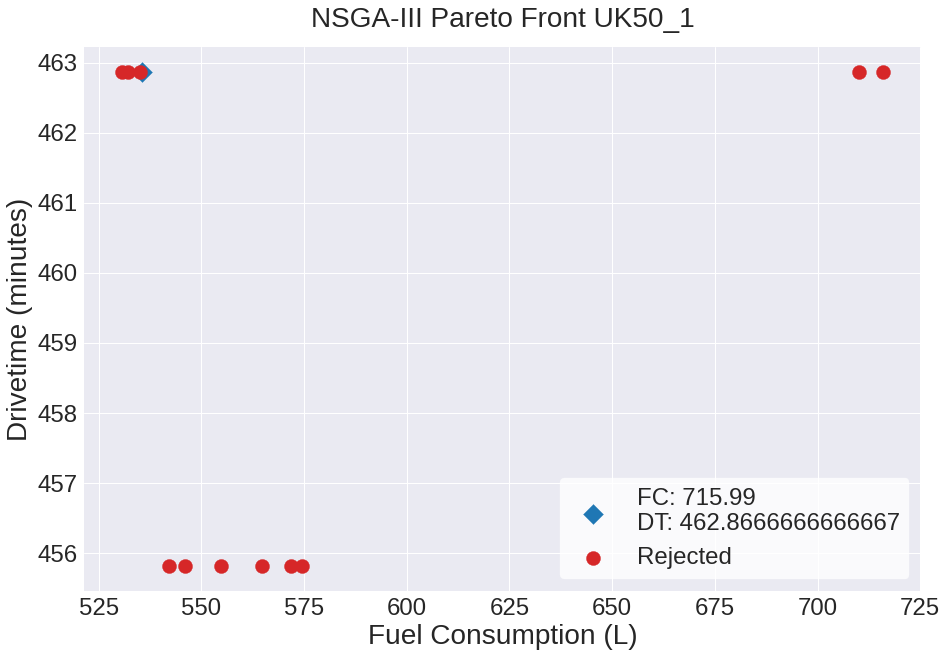

In [18]:

plt.figure(figsize=(15,10))
plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")

rejected_solutions = np.array([sol.objectives for sol in list(filter(lambda x: x != best_sol,front_NSGAIII))])


plt.scatter(x=best_sol.objectives[0],y = best_sol.objectives[1],marker="D",color="tab:blue",s=200,label="FC: {}\nDT: {}".format(np.round(sol.objectives[0],2),sol.objectives[1]))
plt.scatter(x=rejected_solutions[:,0],y = rejected_solutions[:,1],color="tab:red",s=200,label="Rejected")

        

plt.title("NSGA-III Pareto Front UK50_1")
plt.ylabel("Drivetime (minutes)")
plt.xlabel("Fuel Consumption (L)")
legend =plt.legend(frameon=True,fancybox=True)
frame =legend.get_frame()
frame.set_color('white')
plt.savefig("pareto_front_solution_selection_example.pdf")
plt.show()

In [23]:
front_NSGAIII

# UNSGA-III

In [ ]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_UNSGAIII = optimal_parameters["UNSGAIII"]

plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_UNSGAIII = VRP(data_model_input_multi_objective)
    problem_UNSGAIII.name = "NSGA-III"
    problem_UNSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                            population_size=parameters_UNSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_UNSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_UNSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_UNSGAIII])
    performance_observer_UNSGAIII.maxEpochs= amount_of_runs
    performance_observer_UNSGAIII.currentEpoch =  x

    algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
    algorithm_UNSGAIII.run()

    solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
    front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)
    best_sol = sorted(front_UNSGAIII,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,best_sol)

Epoch:5 of 30
Evaluations: 360/3000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 20}
Best fitness: 90.3185 --- 10.7089 --- 21.6448                        
Best total fuel consumption:90.32 
Computing time: 0.3s                        
Average computing speed: 1183.32it/s
Current Route:[['V0', 9, 14, 13, 7, 23, 22], ['V4', 24, 21, 8, 19, 20], ['V3', 11, 1, 18, 25, 5], ['V5', 3, 17, 12, 16, 4]]
Flags: []                        
Violation:0
Vehicle amount:4


In [23]:
get_solution_results(front_UNSGAIII[0],routingContext,vehicles)

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,163.222,03:15:30,2280.0,27.650934,16.940691,50.093708
1,184.223,03:45:05,2033.0,28.538118,15.491072,49.107945
2,149.042,02:38:31,1585.0,22.319021,14.974987,56.413752
3,125.618,02:46:45,2091.0,20.564363,16.370554,45.199880
4,142.617,02:57:35,3431.0,22.901764,16.058228,48.185941
5,97.270,02:31:34,2831.0,17.166401,17.648196,38.505828
6,135.209,03:19:37,2934.0,21.765741,16.097849,40.640594
7,16.633,34:45,1456.0,2.815233,16.925590,28.718849
8,119.834,03:38:00,4814.0,22.926601,19.131966,32.981835


# IBEA

In [12]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime
from Problem.VRPGini import * 
parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
data_model_input_multi_objective["objective_amount"] = 3
for x in range(1):
    problem_IBEA = VRPGini(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    
    best_sol = sorted(front_IBEA,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,best_sol)


Epoch:1 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20}
Best fitness: 66.7321 --- 9.1911 --- 8.4139                        
Best total fuel consumption:66.73 
Computing time: 4.21s                        
Average computing speed: 712.25it/s
Current Route:[['V0', 14, 9, 13, 24, 7, 23, 22], ['V2', 18, 3, 1, 21, 8, 19, 20], ['V4', 11, 25, 12, 16, 17, 4]]
Flags: []                        
Violation:0
Vehicle amount:3


In [44]:
%matplotlib inline
plt.ioff()
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
plots=[]
minx,maxx = np.min(points_coordinate[:,1]),np.max(points_coordinate[:,1])
miny,maxy = np.min(points_coordinate[:,0]),np.max(points_coordinate[:,0])
last_image = 0
final_path  = performance_observer_IBEA.path_history[-1]
created_images = []
for index in tqdm(range(len(performance_observer_IBEA.path_history))):
  
    numerical_path = get_numerical_path(performance_observer_IBEA.path_history[index],vehicles)
    #[56.3957679 -2.0026472]
    #[55.760176  -4.3332046]
    fig,ax = plot_routes(numerical_path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
    fig.set_size_inches(6,6)
    fig.axes[0].set_xlim(-4.5,-2.75)#minx - abs(minx*0.05),maxx+maxx*0.05)
    fig.axes[0].set_ylim(55.7,56.5)#miny-miny*0.01,maxy + maxy*0.01)
#     fig.axes[0].set_xlim(minx - abs(minx*0.3),maxx+maxx*0.3)
#     fig.axes[0].set_ylim(miny-miny*0.002,maxy + maxy*0.002)
    
    fig.axes[0].set_title("Fuel Consumption: {} (L)\nNumber of Vehicles: {}".format(round(performance_observer_IBEA.total_consumptions[index],2),len(performance_observer_IBEA.path_history[index])),fontsize=16,rasterized=True)
    
    fig.axes[0].text( 0.2, 0.15,"Computation Time: {} seconds".format(round(performance_observer_IBEA.computationTimes[index],1)), fontsize=16, transform=plt.gcf().transFigure,rasterized=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    new_file_path = "./test_folder/{}.png".format(index)
    fig.savefig(new_file_path)
    if len(created_images) == 0:
        for _ in range(20):
            created_images.append(new_file_path)
    
    
    created_images.append(new_file_path)

    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if len(plots) == 0:
        for _ in range(20):
            plots.append(image)
    
    plots.append(image)
    last_image = image
    plt.close(fig)
    if final_path == performance_observer_IBEA.path_history[index]:
        print("DONE")
        break
    
    
for _ in range(20):
    created_images.append(new_file_path) 
    plots.append(image)


  0%|          | 0/150 [00:00<?, ?it/s]

DONE


In [47]:
for _ in range(50):
    created_images.append(new_file_path) 

In [32]:
# Build GIF
import imageio 
with imageio.get_writer('mygif.gif', mode='I',fps=20) as writer:
    for filename in created_images:
        image = imageio.imread(filename)
        writer.append_data(image)

In [53]:
from PIL import Image  
img, *imgs = [Image.open(f) for f in created_images]
for _ in range(50):
    imgs.append(imgs[-1])


img.save(fp="./"+"test5"+'1.gif', format='GIF', append_images=imgs,
     save_all=True, loop=3)

In [26]:
kwargs_write = {'fps':20, 'quantizer':'nq'}

In [34]:
import imageio 
imageio.mimsave('./test3.gif', plots,format='GIF-FI',**kwargs_write)

In [29]:
import imageio 
imageio.mimsave('./test4.gif', plots, fps=20,format='GIF-FI')

In [9]:
numerical_path = get_numerical_path(best_sol.path,vehicles)
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in numerical_path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


In [11]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black","darkgreen"]
type_colors=["black","red","green"]
numerical_path = get_numerical_path(best_sol.path,vehicles)
numerical_route = numerical_path#get_numerical_path([['V0', 14, 9, 13, 24, 7, 23, 22], ['V2', 18, 3, 1, 21, 8, 19, 20], ['V4', 25, 11, 16, 12, 17, 4]],vehicles)
for routeNumber,route in enumerate(numerical_route):
    icons = {0:"trash",1:"industry",2:"truck",3:'car'}
    type_colors=["black","red","green"]
    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        pos_icon = icons[nodeType]
        
        
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00',prefix="fa",icon=pos_icon),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(vehicle_routes[routeNumber],color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


[['V0', 42, 33, 30, 19, 34, 16, 2],
 ['V6', 31, 37, 26, 2],
 ['V3', 48, 4],
 ['V4', 11, 18, 39, 20],
 ['V7', 47, 46, 24, 27, 2],
 ['V2', 50, 44, 7, 8, 2],
 ['V9', 36, 17, 25, 13, 14, 29, 38, 2],
 ['V10', 41, 45],
 ['V12', 49, 3, 12, 23, 9, 28, 20],
 ['V13', 22, 43, 20]]

In [100]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine,CircleMarker
from folium.plugins import HeatMap, MarkerCluster
def plot_routes_with_congestion_folium(vehicle_solutions_path, points_coordinate, dbf,colors,congestion_edge=None,locked_paths=None,station_ids = False,prerocessed_paths=None, here_api = False, api_key=""):
    
    vehicle_solutions = get_numerical_path(vehicle_solutions_path,vehicles)
    
    folium_map = folium.Map(np.mean(points_coordinate,axis=0),zoom_control=False  ,zoom_start=10,min_zoom=10)#,tiles = "cartodbdark_matter")
    icons = {0:"trash",1:"industry",2:"truck",3:'car'}
    type_colors=["black","red","green"]
    
    
    congestion_plot_coordinates = np.array([points_coordinate[congestion_edge[0]],points_coordinate[congestion_edge[1]]]) if congestion_edge else None
    print(congestion_plot_coordinates)
        
    for vehicle_id in range(len(vehicle_solutions)):
        print(vehicle_id)
        plot_color = colors[list(colors.keys())[vehicle_id]]
        
        vehicle_stops_coordinates=points_coordinate[vehicle_solutions[vehicle_id], :]
        vehicle_route = vehicle_stops_coordinates
        
        if here_api:
            if type(prerocessed_paths) != None:
                vehicle_route = prerocessed_paths[vehicle_id]
            else:
                vehicle_route_encoded = generate_routes(vehicle_stops_coordinates, api_key=api_key)
                vehicle_route_decoded = decode_routes(vehicle_route_encoded)
                total_vehicle_route = []
                for route in vehicle_route_decoded:
                    for cords in route:
                        total_vehicle_route.append(cords)
                vehicle_route = np.array(total_vehicle_route)
        
        PolyLine(vehicle_route,weight=5,color=plot_color).add_to(folium_map)
        
        
        
    planted_start_stop_ids=[]
    for vehicle_id in range(len(vehicle_solutions)):
        
        locked_vehicle_path = get_numerical_path([locked_paths[vehicle_solutions_path[vehicle_id][0]]],vehicles) if congestion_edge else [-1]
        
        
        plot_color =colors[list(colors.keys())[vehicle_id]]
        
        vehicle_stops_coordinates=points_coordinate[vehicle_solutions[vehicle_id], :]
        vehicle_route = vehicle_stops_coordinates
        vehicle_string = vehicle_solutions_path[vehicle_id][0]
        
    
    
        for stop_index, vehicle_stop in enumerate(vehicle_stops_coordinates):
            stop_coordinates = (vehicle_stop[0],vehicle_stop[1])
            node_type = 0
            
            if stop_index == 0:
                if int(vehicle_string[1:]) % 2 ==0:
                    node_type = 2
                else:
                    node_type = 3
                
            elif stop_index == len(vehicle_stops_coordinates)-1:
                node_type = 1
                
            pos_icon = icons[node_type]
            
            if node_type == 0:
                CircleMarker(stop_coordinates,color="#4b4d4d",fillColor="#4b4d4d",fill_opacity=.9,fill=True,radius=5).add_to(folium_map)
            else:
                
                beautiful_icon = folium.plugins.BeautifyIcon(color="white",iconSize=(35,35),inner_icon_style='font-size:20px',innerIconAnchor=(0,5),text_color=plot_color,icon=pos_icon,prefix="fa",border_width=2)
                offset=np.array([0,0])
                current_pos  = vehicle_solutions[vehicle_id][stop_index]
                
                occurence_offsets = {1:np.array([0.008,0.01]),2:np.array([0.008,-0.01]),3:np.array([-0.012,0.01]),4:np.array([-0.012,-0.02]),5:np.array([0,0.025])}
                
                
                if current_pos in planted_start_stop_ids and node_type in [2,3]:
                    offset=+np.array([0.008,0.01])
                    
                elif current_pos in planted_start_stop_ids and node_type ==1 :
                    offset= occurence_offsets[planted_start_stop_ids.count(current_pos)]
                    print(planted_start_stop_ids.count(current_pos), plot_color)
#                     amount_of_ends = planted_start_stop_ids.count(current_pos)
#                     test_icon = folium.plugins.BeautifyIcon(color="white",iconSize=(35,35),inner_icon_style='font-size:24px',innerIconAnchor=(0,-2),text_color=plot_color,number=amount_of_ends,prefix="fa",border_width=2)
#                     Marker(tuple(np.array(stop_coordinates)+np.array([0.0,0.04])),icon=test_icon).add_to(folium_map)
                    
                planted_start_stop_ids.append(current_pos)
                Marker(tuple(np.array(stop_coordinates)+ offset)  ,icon=beautiful_icon).add_to(folium_map)
                    
                    
                
        #planted_start_stop_ids.append(vehicle_solutions[vehicle_id][0])
        #planted_start_stop_ids.append(vehicle_solutions[vehicle_id][-1])
        
        
        
        
    if congestion_edge != None:
        congestion_route =congestion_plot_coordinates
        if here_api:
        
        
            congestion_route_encoded = generate_routes(congestion_plot_coordinates, api_key=api_key)
            congestion_route_decoded = decode_routes(congestion_route_encoded)
            total_congestion_route = []
            for route in congestion_route_decoded:
                    for cords in route:
                        total_congestion_route.append(cords)
            congestion_route = np.array(total_congestion_route)

        PolyLine(congestion_route,color="red",weight=6,dash_array='10').add_to(folium_map)
    
    #max_point =  [max(points_coordinate[:,0]), max(points_coordinate[:,1])]
    #min_point =  [min(points_coordinate[:,0]), min(points_coordinate[:,1])-0.6]
    #folium_map.fit_bounds([min_point,max_point])
    
#     if congestion_edge:
#         folium_map.position =(5,5)# np.mean([points_coordinate[congestion_edge[0]], points_coordinate[congestion_edge[1]]],axis=0) + np.array([1,-5])
    
    
    
    #folium_map.position = tuple(np.mean([max_point,min_point],axis=0))+(1,5)
    return folium_map

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy as sp
from copy import deepcopy
def get_vehicle_color_map2(vehicles):
    
    color_list = deepcopy(mcolors.TABLEAU_COLORS)
    del color_list["tab:red"]
  
    colors = list(color_list.values())
    colors.append("k")
    color_map = {}

    for vehicle_key,color in zip(vehicles,colors):
        color_map[vehicle_key] = color
    return color_map
color_map = get_vehicle_color_map2(vehicles)
#preprocessed_paths_normal= preprocess_vehicle_paths(nsga3_numerical_path,points_coordinate,api)
color_map_2 =get_vehicle_color_map2(vehicles)
color_map_2

{'V0': '#1f77b4',
 'V1': '#ff7f0e',
 'V2': '#2ca02c',
 'V3': '#9467bd',
 'V4': '#8c564b',
 'V5': '#e377c2',
 'V6': '#7f7f7f',
 'V7': '#bcbd22',
 'V8': '#17becf',
 'V9': 'k'}

In [104]:
get_numerical_path

<function Problem.VehicleFunctions.get_numerical_path(path, vehicles)>

In [103]:
plot_routes_with_congestion_folium(best_sol.path,points_coordinate,dbf,colors=color_map_2,station_ids = True,here_api=False, api_key=api)

None
0
1
2
3
4
5
6
7
8
9
10


IndexError: list index out of range